# Exploratory data analysis of the MIT-BIH Arrhythmia Database

After installing the provided utility, you can first (for reproducibility) download the data using the CLI tool:

```bash
volta_download_data
```
This will automatically download the daya in `./data/mitdb`. You can also get the path using the `voltatest` provided package.

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# Ge download path for the MIT-BIH Arrhythmia Database
from voltatest.download import dl_dir
dl_dir

PosixPath('/Users/ssilvari/PycharmProjects/volta-test/data/mitdb')

## Understanding data structure
According to the [documentation](https://physionet.org/content/mitdb/1.0.0/), each ECG contains two channels. For QC. let's verify that this is the case.

In [3]:
# Importing the data
from voltatest.data import MITBIHDataset

dataset = MITBIHDataset(dl_dir=dl_dir)

print(f'Total number of ECGs: {len(dataset)}')

Total number of ECGs: 48


However, according to the Database docs, only 25 are complete. Let's see the sample distribution.

In [4]:
import pandas as pd

records_info = []
for record, annotation in dataset:
    records_info.append({
        'record': record.record_name,
        'record_length': len(record.p_signal),
        'channels': record.n_sig,
        'sampling_rate': record.fs,
        'annotation_length': len(annotation.sample)
    })

records_info = pd.DataFrame(records_info)

In [5]:
records_info

,record,record_length,channels,sampling_rate,annotation_length
0,213,650000,2,360,3294
1,207,650000,2,360,2385
2,212,650000,2,360,2763
3,210,650000,2,360,2685
4,205,650000,2,360,2672
5,201,650000,2,360,2039
6,215,650000,2,360,3400
7,214,650000,2,360,2297
8,200,650000,2,360,2792
9,228,650000,2,360,2141


<Axes: xlabel='sampling_rate', ylabel='record'>

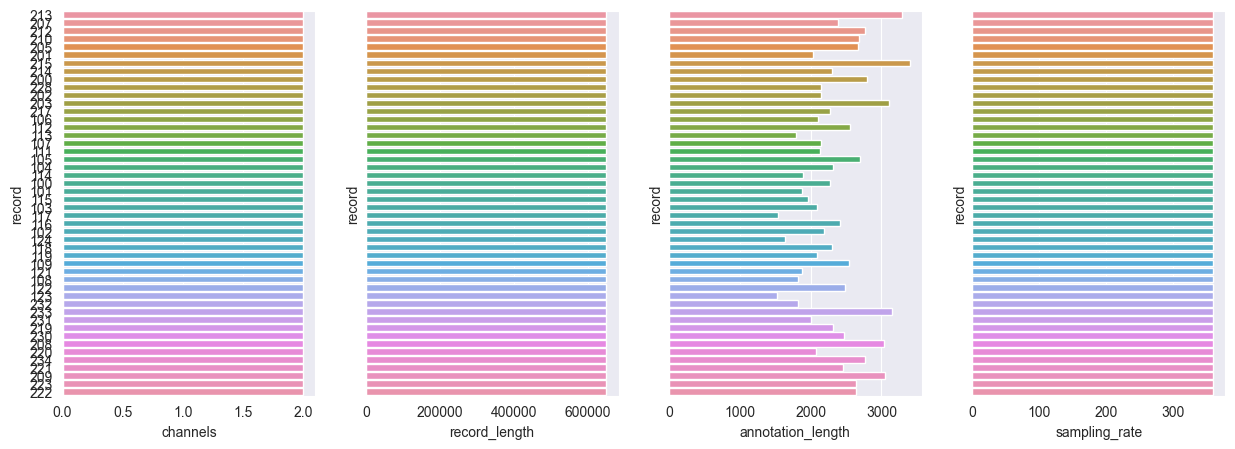

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
# Plot the number of channels per each record
sns.barplot(y='record', x='channels', data=records_info, ax=axs[0])

# Plot the number of samples per each record
sns.barplot(y='record', x='record_length', data=records_info, ax=axs[1])

# Number of annotations per each record
sns.barplot(y='record', x='annotation_length', data=records_info, ax=axs[2])

# Sampling rate per each record
sns.barplot(y='record', x='sampling_rate', data=records_info, ax=axs[3])

This allows us to see that the dataset is clean and that we must choose a method that

Record Name                 203
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      3108


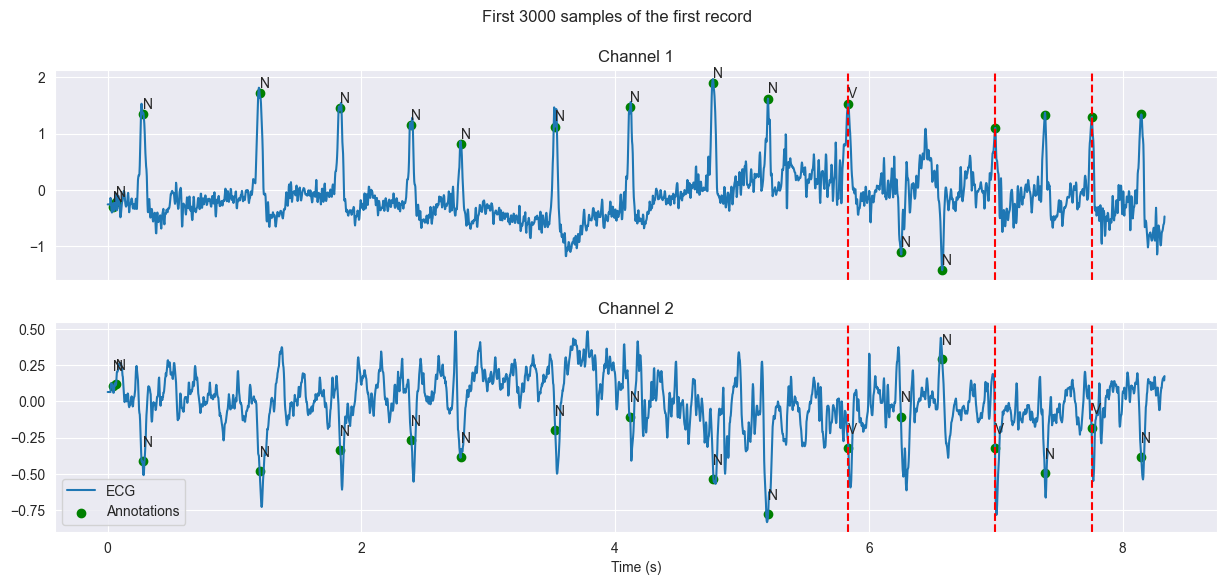

In [7]:
# Plotting the first 3000 samples of the first record
import random

# Use our coded visualization tool
from voltatest.visualize import plot_first_n_samples

# random.seed(42) # For reproducibility

# Choose random record
record, annotation = random.choice(dataset)

plot_first_n_samples(record, annotation, n_samples=3000)
plt.show()


The vertical lines highlight the abnormal annotations. Let's see the distribution of the annotations.

In [20]:
import pandas as pd

annotations_dataset = []

for _, annotation in dataset:
    for i, sample_idx in enumerate(annotation.sample):
        data = {
            'record_name': annotation.record_name,
            'symbol': annotation.symbol[i],
            'index': sample_idx
        }
        annotations_dataset.append(data)

annot_df = pd.DataFrame(annotations_dataset)

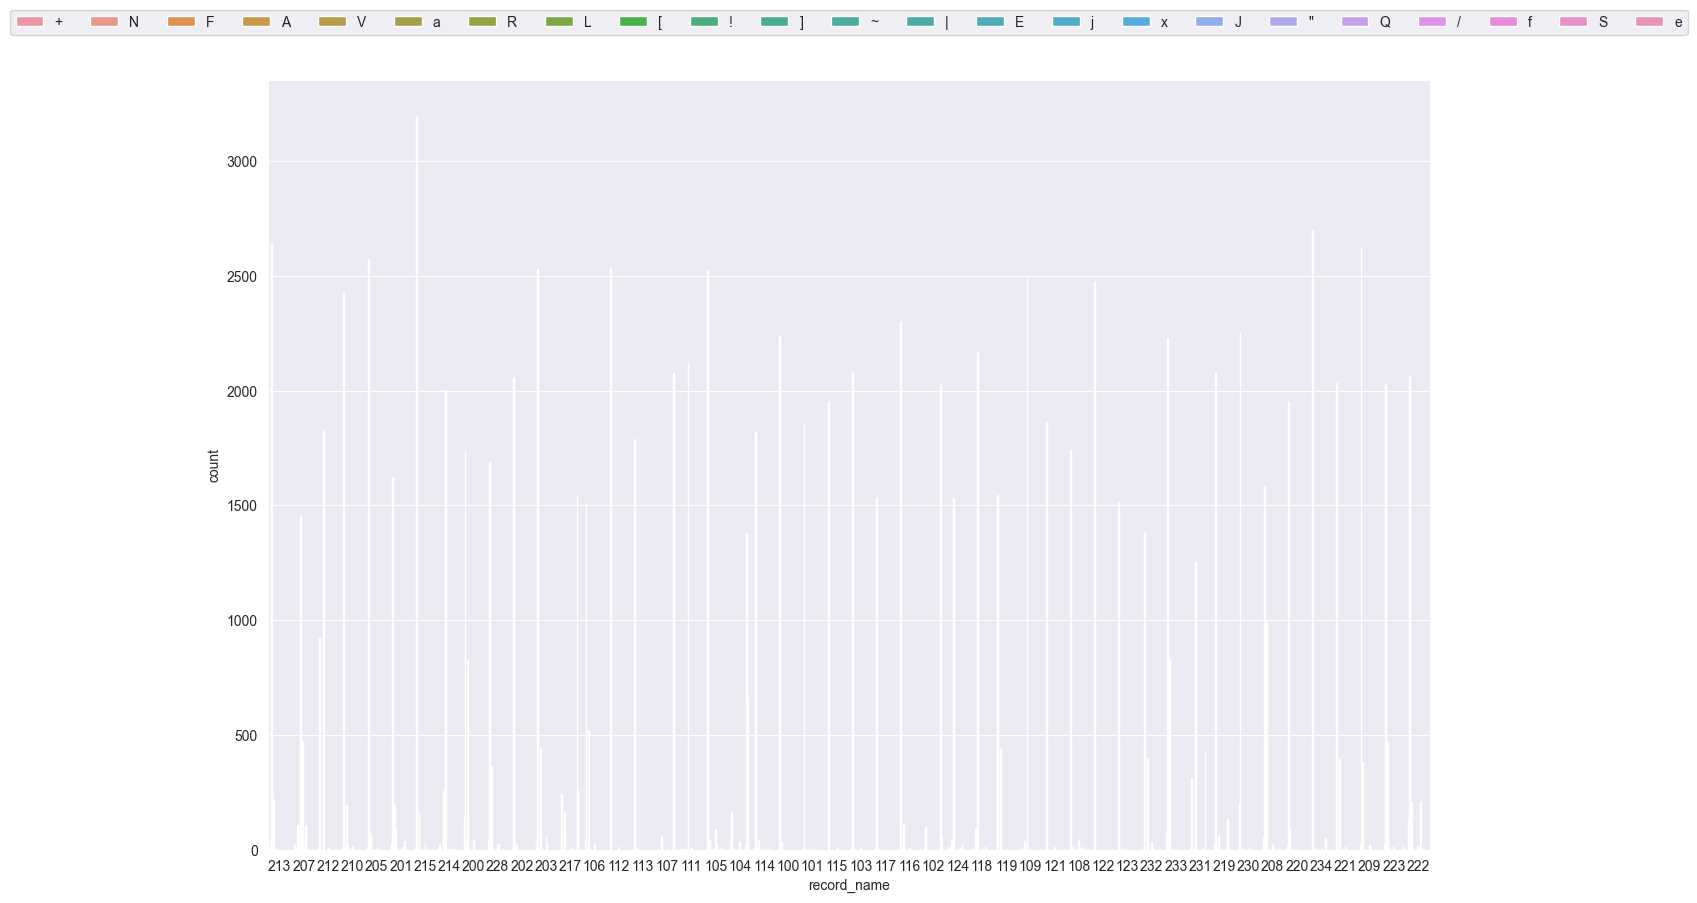

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x='record_name', hue='symbol', data=annot_df, ax=ax)
# Place legend on top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(annot_df.symbol.unique()))

In [43]:
print(annot_df.symbol.value_counts().to_markdown())

| symbol   |   count |
|:---------|--------:|
| N        |   75052 |
| L        |    8075 |
| R        |    7259 |
| V        |    7130 |
| /        |    7028 |
| A        |    2546 |
| +        |    1291 |
| f        |     982 |
| F        |     803 |
| ~        |     616 |
| !        |     472 |
| "        |     437 |
| j        |     229 |
| x        |     193 |
| a        |     150 |
| |        |     132 |
| E        |     106 |
| J        |      83 |
| Q        |      33 |
| e        |      16 |
| ]        |       6 |
| [        |       6 |
| S        |       2 |


According to the annotation list, this dataset contains the following annotations [source](https://archive.physionet.org/physiobank/annotations.shtml):



In [44]:
# Create the dictionary mapping symbols to meanings
meanings = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Ventricular escape beat',
    'V': 'Premature ventricular contraction',
    '/': 'P-wave peak',
    'A': 'Atrial premature beat',
    '+': 'Rhythm change (non-specific)',
    'f': 'F-wave peak',
    'F': 'Fusion of ventricular and normal beat',
    '~': 'T-wave peak',
    '!': 'Rhythm change (specific)',
    '"': 'Paced beat (fusion)',
    'j': 'Nodal (junctional) premature beat',
    'x': 'Non-conducted P-wave (extra systolic P-wave)',
    'a': 'Aberrated atrial premature beat',
    '|': 'T-wave end',
    'E': 'Ventricular flutter wave',
    'J': 'Nodal (junctional) escape beat',
    'Q': 'Unclassifiable beat',
    'e': 'Atrial escape beat',
    ']': 'Non-conducted P-wave (blocked APC)',
    '[': 'Paced beat',
    'S': 'Supraventricular premature beat'
}

In [52]:
annot_df['Description'] = annot_df['symbol'] + ' - ' + annot_df['symbol'].map(meanings)
print(annot_df['Description'].value_counts().to_markdown())

| Description                                      |   count |
|:-------------------------------------------------|--------:|
| N - Normal beat                                  |   75052 |
| L - Left bundle branch block beat                |    8075 |
| R - Ventricular escape beat                      |    7259 |
| V - Premature ventricular contraction            |    7130 |
| / - P-wave peak                                  |    7028 |
| A - Atrial premature beat                        |    2546 |
| + - Rhythm change (non-specific)                 |    1291 |
| f - F-wave peak                                  |     982 |
| F - Fusion of ventricular and normal beat        |     803 |
| ~ - T-wave peak                                  |     616 |
| ! - Rhythm change (specific)                     |     472 |
| " - Paced beat (fusion)                          |     437 |
| j - Nodal (junctional) premature beat            |     229 |
| x - Non-conducted P-wave (extra systolic P-wave) |   

In [64]:
order

Index(['N - Normal beat', 'L - Left bundle branch block beat',
       'R - Ventricular escape beat', 'V - Premature ventricular contraction',
       '/ - P-wave peak', 'A - Atrial premature beat',
       '+ - Rhythm change (non-specific)', 'f - F-wave peak',
       'F - Fusion of ventricular and normal beat', '~ - T-wave peak',
       '! - Rhythm change (specific)', '" - Paced beat (fusion)',
       'j - Nodal (junctional) premature beat',
       'x - Non-conducted P-wave (extra systolic P-wave)',
       'a - Aberrated atrial premature beat', '| - T-wave end',
       'E - Ventricular flutter wave', 'J - Nodal (junctional) escape beat',
       'Q - Unclassifiable beat', 'e - Atrial escape beat',
       '] - Non-conducted P-wave (blocked APC)', '[ - Paced beat',
       'S - Supraventricular premature beat'],
      dtype='object', name='Description')

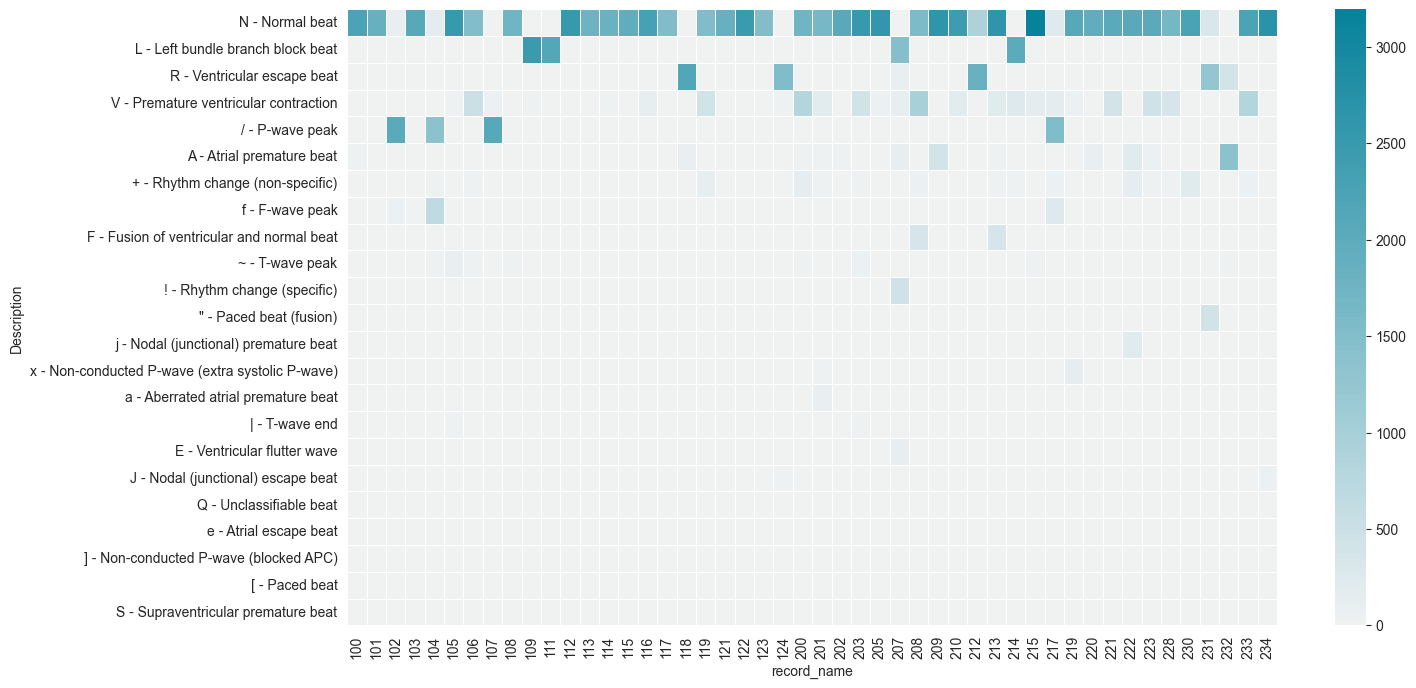

In [122]:
import numpy as np
order = annot_df['Description'].value_counts().index # Order frequency wise (desc)
cross_tab_annot_freq = pd.crosstab(annot_df['Description'], annot_df['record_name']).loc[order]

palette = sns.diverging_palette(10, 220, n=256, s=99, l=50, as_cmap=True)

plt.subplots(figsize=(15, 8))
ax = sns.heatmap(cross_tab_annot_freq, vmin=0, linewidths=0.5, center=0, cmap=palette)

In [124]:
print(f'Total number of classes:', len(annot_df.Description.unique()))

Total number of classes: 23


In [127]:
print(annot_df.Description.unique())

['+ - Rhythm change (non-specific)' 'N - Normal beat'
 'F - Fusion of ventricular and normal beat' 'A - Atrial premature beat'
 'V - Premature ventricular contraction'
 'a - Aberrated atrial premature beat' 'R - Ventricular escape beat'
 'L - Left bundle branch block beat' '[ - Paced beat'
 '! - Rhythm change (specific)' '] - Non-conducted P-wave (blocked APC)'
 '~ - T-wave peak' '| - T-wave end' 'E - Ventricular flutter wave'
 'j - Nodal (junctional) premature beat'
 'x - Non-conducted P-wave (extra systolic P-wave)'
 'J - Nodal (junctional) escape beat' '" - Paced beat (fusion)'
 'Q - Unclassifiable beat' '/ - P-wave peak' 'f - F-wave peak'
 'S - Supraventricular premature beat' 'e - Atrial escape beat']
